# Assignment 2 Part 1: Texture Mapping

In this assignment, you are going to learn about wrapping a mesh with a texture map.

In [1]:
import slangpy as spy
from pyglm import glm
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import open3d as o3d
from enum import Enum

from cs248a_renderer import setup_device, RendererModules
from cs248a_renderer.model.mesh import Mesh
from cs248a_renderer.model.material import PhysicsBasedMaterial, MaterialField, FilteringMethod
from cs248a_renderer.model.scene import Scene
from cs248a_renderer.renderer.core_renderer import Renderer
from cs248a_renderer.model.volumes import DenseVolume
from cs248a_renderer.model.transforms import Transform3D

objc[5150]: Class GLFWHelper is implemented in both /Users/anniev18/Desktop/CS248A/asst2/.venv/lib/python3.12/site-packages/slangpy/libsgl.dylib (0x10c779248) and /Users/anniev18/Desktop/CS248A/asst2/.venv/lib/python3.12/site-packages/open3d/cpu/pybind.cpython-312-darwin.so (0x11b80fa28). This may cause spurious casting failures and mysterious crashes. One of the duplicates must be removed or renamed.
objc[5150]: Class GLFWApplicationDelegate is implemented in both /Users/anniev18/Desktop/CS248A/asst2/.venv/lib/python3.12/site-packages/slangpy/libsgl.dylib (0x10c779298) and /Users/anniev18/Desktop/CS248A/asst2/.venv/lib/python3.12/site-packages/open3d/cpu/pybind.cpython-312-darwin.so (0x11b80fa78). This may cause spurious casting failures and mysterious crashes. One of the duplicates must be removed or renamed.
objc[5150]: Class GLFWWindowDelegate is implemented in both /Users/anniev18/Desktop/CS248A/asst2/.venv/lib/python3.12/site-packages/slangpy/libsgl.dylib (0x10c7792c0) and /Users

In [2]:
# Device setup
device = setup_device([])
renderer_modules = RendererModules(device)

[INFO] (rhi) layer: CreateDevice: Debug layer is enabled.
[WARN] No supported shader model found, pretending to support sm_6_0.
[WARN] Slang compiler warnings:
/Users/anniev18/Desktop/CS248A/asst2/src/cs248a_renderer/slang_shaders/./primitive/volume.slang(25): warning 41010: non-void function does not return in all cases
    public Optional<RayHitResult> hit(Ray ray, SharedTexture3DBuffer<float4> volumeTexBuf)
                                  ^~~



In [3]:
# We setup the output image
OUTPUT_IMG_SIZE = (512, 512)
output_image = device.create_texture(
    type=spy.TextureType.texture_2d,
    format=spy.Format.rgba32_float,
    usage=spy.TextureUsage.unordered_access,
    width=OUTPUT_IMG_SIZE[0],
    height=OUTPUT_IMG_SIZE[1],
)

In [4]:
renderer = Renderer(
    device=device,
    render_texture=output_image,
    render_modules=renderer_modules
)

#### Download the requires meshes
We are going to work with a simple triangle and plane meshes to drive home the point of texture mapping. Please download `triangle.obj` and `plane.obj` from the assignment 2 resources folder: [https://drive.google.com/drive/folders/1biYrBrNYx1sBlkcuyx3RARH9g9PaVHgL?usp=drive_link](https://drive.google.com/drive/folders/1biYrBrNYx1sBlkcuyx3RARH9g9PaVHgL?usp=drive_link)

Place these files in the `resources` folder under the root directory of the repository (e.g., if your repository is located at `/path/to/cs248a-assignment2`, place the files in `/path/to/cs248a-assignment2/resources`). **Note:** This directory is ignored by `.gitignore`, so if you are working with your partner in group, make sure both of you have the files in your local `resources` folder.

### Defining material for the surface
So far, we've assumed that the surfaces that we are rendering are having a uniform color. Let's talk about it more formally now. A surface has a material. For eg. it could be a glossy surface (like plastic), metallic surface, diffused surface (most common, like wood, stone, found in everyday natural objects). In this noteobok we are going to assume that our surface has diffused material. We'll be rendering other kinds of materials in the upcoming assignments.

Below, we begin with rendering a triangle in the same way that you did in the last assignment. While we do that, we are going to define the material in this triangle with a `PhysicsBasedMaterial`, whose properties are defined by `MaterialField`. We'll set its color to be while, which is defined in the `uniform_value`. This is the default color to be rendered in the absence of the albedo texture map, which has been the case so far in the course.

In [5]:
# We'll load a Triangle into our scene. This triangle is a right triangle of side length 100.
scene = Scene()
o3d_mesh = o3d.io.read_triangle_mesh("../../resources/triangle.obj")
mesh = Mesh(o3d_mesh)
mesh.transform = Transform3D(
    position=glm.vec3(0.0),

)
############## DEFINING A UNIFORM MATERIAL ###########
mesh.material = PhysicsBasedMaterial(
    albedo=MaterialField(
        uniform_value=glm.vec3(1.0, 1.0, 1.0),
        use_texture=False,
        filtering_method=FilteringMethod.NEAREST,
    ),
)
#######################################################

scene.add_object(mesh)
scene

SceneObject(name=root, transform=Transform3D(position=vec3( 0, 0, 0 ), rotation=quat( 1, 0, 0, 0 ), scale=vec3( 1, 1, 1 )), children=[
  SceneObject(name=object_1, transform=Transform3D(position=vec3( 0, 0, 0 ), rotation=quat( 1, 0, 0, 0 ), scale=vec3( 1, 1, 1 )), children=[
  ])
])

In [6]:
cam = scene.camera
eye = glm.vec3(50.0, 50.0, 200.0)
lookAt = glm.vec3(50.0, 50.0, 0.0)

cam.transform.position = eye
cam.transform.rotation = glm.quatLookAt(glm.normalize(lookAt-eye), glm.vec3(0.0, 1.0, 0.0))
scene


SceneObject(name=root, transform=Transform3D(position=vec3( 0, 0, 0 ), rotation=quat( 1, 0, 0, 0 ), scale=vec3( 1, 1, 1 )), children=[
  SceneObject(name=object_1, transform=Transform3D(position=vec3( 0, 0, 0 ), rotation=quat( 1, 0, 0, 0 ), scale=vec3( 1, 1, 1 )), children=[
  ])
])

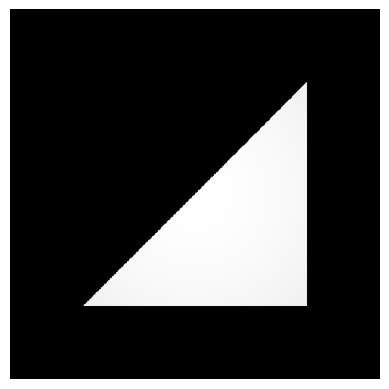

In [7]:
renderer.load_triangles(scene=scene)
renderer.render(
    scene.camera.view_matrix(),
    scene.camera.fov
)
plt.imshow(np.flipud(output_image.to_numpy()))
plt.axis('off')
plt.show()

### UV Map
Each mesh comes with vertices, and their corresponding UV coordinates. If you open any `.obj` file, the UV coordinates of a vertex are prefixed by `vt`. A `.obj` file first defines vertices followed by their corresponding UV coordinates, in the same order as vertices. These UV coordinates are used to sample the texture map to fetch albedo at vertex location.
As you mgiht have guessed, we are not rendering just the vertices but the surface defined by them. Therefore, to color a surface we'd have to itnerpolate the UV coordinate at every hit point of ray-triangle intersection (which may not always be the vertex). To interpolate the UV coordinate at all locations on a triangle surface we take the help of Barycentric Coordinates.

#### Barycentric Coordinates
Barycentric Coordinates provide a method to interpolate between 3 points. The essence is very similar to the bilinear interpolation, which interpolates over a rectangle defined by 4 support points. Just like in bilinear interpolation, where the weights are defined by the ration area of the rectangles, the barycentric coordinates are defined by the ratio of the area of triangle subtended by the hitpoint to the edges.

Implement `calculateBarycentricCoord` in the file `src/cs248a_renderer/slang_shaders/primitive/triangle.slang`. Then visualize the barycentric coordinates over the triangle that we just defined by setting the flag `visualize_barycentric_coords=True` in the `renderer.render`. This visualization shows the influence of each vertex on the surface. Red is highest influence of vertex 0 (bottom left), Green is for vertex 1 (bottom right) and Blue is for vertex 2 (top left).

![Barycentric Coordinates](../../assets/bary.png)

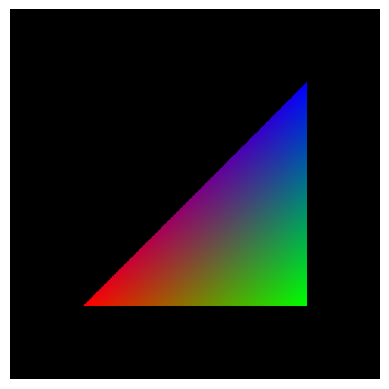

In [8]:
renderer.render(
    scene.camera.view_matrix(),
    scene.camera.fov,
    visualize_barycentric_coords=True
)
plt.imshow(np.flipud(output_image.to_numpy()))
plt.axis('off')
plt.show()

### UV Coordinates
Now we'll go ahead and interpolate the UV coordinates using the weights defined by the barycentric coordinates.

Let's visualize the UV coordinates over the triangle by setting the flag `visualize_tex_uv=True` in the `renderer.render`.

![Texture UV](../../assets/uv.png)

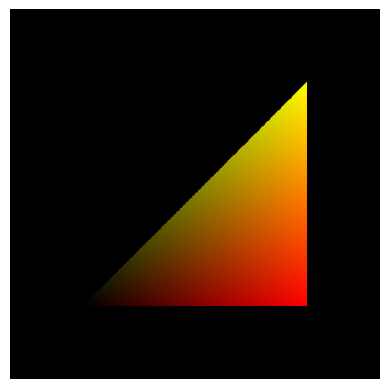

In [9]:
# To visualize UV as RGB, we map UV to RG and fix B to 0.0.
renderer.render(
    scene.camera.view_matrix(),
    scene.camera.fov,
    visualize_tex_uv=True
)
plt.imshow(np.flipud(output_image.to_numpy()))
plt.axis('off')
plt.show()

In [10]:
# Helper functions to get a meshed object
class MaterialType(Enum):
    UNIFORM = 'uniform'
    ALBEDO_TEXTURE = 'albedo_texture'

class ObjectType(Enum):
    TRIANGLE = 'triangle'
    PLANE = 'plane'

def getObject(object_type=ObjectType.PLANE, material=MaterialType.UNIFORM, \
              filtering_method=FilteringMethod.NEAREST, \
              texture_map_path: str=None):
    # We'll load a Plane into our scene, having side length 100.
    if object_type == ObjectType.TRIANGLE:
        o3d_mesh = o3d.io.read_triangle_mesh("../../resources/triangle.obj")
    elif object_type == ObjectType.PLANE:
        o3d_mesh = o3d.io.read_triangle_mesh("../../resources/plane.obj")
    else:
        raise ValueError(f"Invalid object type: {object_type}")
    mesh = Mesh(o3d_mesh)
    mesh.transform = Transform3D(
        position=glm.vec3(0.0),

    )
    if material == MaterialType.UNIFORM:
        mesh.material = PhysicsBasedMaterial(
            albedo=MaterialField(
                uniform_value=glm.vec3(1.0, 1.0, 1.0),
                use_texture=False,
                filtering_method=filtering_method,
            ),
        )
    elif material == MaterialType.ALBEDO_TEXTURE:
        if texture_map_path is None:
            raise ValueError("Texture map path is required for ALBEDO_TEXTURE material")

        mesh.material = PhysicsBasedMaterial(
            albedo=MaterialField(
                uniform_value=glm.vec3(1.0, 1.0, 1.0),
                use_texture=True,
                filtering_method=filtering_method,
                texture_map_path=texture_map_path,
            ),
        )
    else:
        raise ValueError(f"Invalid material type: {material}")
    mesh.transform = Transform3D(
        position=glm.vec3(0.0),
    )
    return mesh

Let's look at the full UV map over a plane. Make sure you've downloaded the plane from [here](https://drive.google.com/file/d/1xaQgIj65Qc2nYXvqm8CC1wLVrDrGedRs/view?usp=drive_link) and placed it in the `resources` folder in the root directory of this assignment.

In [11]:
# We'll load a Plane into our scene, having side length 100.
scene = Scene()
mesh = getObject(object_type=ObjectType.PLANE, material=MaterialType.UNIFORM)
scene.add_object(mesh)
cam = scene.camera
eye = glm.vec3(50.0, 50.0, 200.0)
lookAt = glm.vec3(50.0, 50.0, 0.0)

cam.transform.position = eye
cam.transform.rotation = glm.quatLookAt(glm.normalize(lookAt-eye), glm.vec3(0.0, 1.0, 0.0))
scene

SceneObject(name=root, transform=Transform3D(position=vec3( 0, 0, 0 ), rotation=quat( 1, 0, 0, 0 ), scale=vec3( 1, 1, 1 )), children=[
  SceneObject(name=object_3, transform=Transform3D(position=vec3( 0, 0, 0 ), rotation=quat( 1, 0, 0, 0 ), scale=vec3( 1, 1, 1 )), children=[
  ])
])

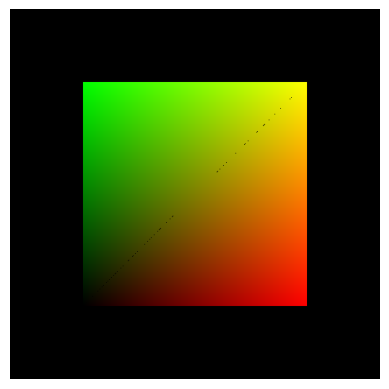

In [12]:
# To visualize UV as RGB, we map UV to RG and fix B to 0.0.
renderer.load_triangles(scene=scene)
renderer.render(
    scene.camera.view_matrix(),
    scene.camera.fov,
    visualize_tex_uv=True
)
plt.imshow(np.flipud(output_image.to_numpy()))
plt.axis('off')
plt.show()

## Wrapping A Texture Onto The Plane
After learning about how to get UV coordinates for any point on the surface, we are now ready to use it to wrap a texture on a surface. When we go to try that, we find two cases: a) what if the the texture map is too tiny compared to the surface? b) Or, what if it is too large?

### Texture Magnification
This happens when the area of texture map is much smaller than the area of mesh on which we want to wrap it. To demonstrate this, we are going to define a texture of size 2x2 containing 4 colors, RGBY. Then, we'll wrap it on the plane and render it, such that the plane occupies the whole image canvas of size 512x512.

Since we are mapping a tiny texture map onto a large canvas, we need to think of a way to estimate the color for the pixels, where the UV coordinates do not map to a texel (pixel of texture map).

#### Download Tiny Texture

Download the `tiny_texture.png` from the assignment 2 resources folder: [https://drive.google.com/file/d/16vCrZx4ZKK9xaih-BV12COz4yEMZUnDH/view?usp=drive_link](https://drive.google.com/file/d/16vCrZx4ZKK9xaih-BV12COz4yEMZUnDH/view?usp=drive_link)

Place it in the `resources` folder under the root directory of the repository (e.g., if your repository is located at `/path/to/cs248a-assignment2`, place the files in `/path/to/cs248a-assignment2/resources`). **Note:** This directory is ignored by `.gitignore`, so if you are working with your partner in group, make sure both of you have the files in your local `resources` folder.

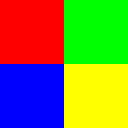

In [13]:
TINY_TEXTURE_IMAGE_PATH = "../../resources/tiny_texture.png"
tiny_texture_img = Image.open(TINY_TEXTURE_IMAGE_PATH)
# Visualize the tiny texture, resize it to 128x128 for visualization purposees
tiny_texture_img.resize((128, 128), Image.NEAREST)

#### Nearest Sampling
In this method, we set the color of the pixel to the texel at the nearest UV coordinate to it's corresponding one.
Implement `pointSample` function of `struct SharedTexture2DBuffer` in file `src/cs248a_renderer/slang_shaders/texture/texture.slang`. Upon a successful implementation, rendering a plane with this texture onto a 512x512 sized canvas should get the following blocky output:

![nearest](../../assets/nearest.png)

In [14]:
scene = Scene()
mesh = getObject(object_type=ObjectType.PLANE,\
                material=MaterialType.ALBEDO_TEXTURE,\
                filtering_method=FilteringMethod.NEAREST,\
                texture_map_path=TINY_TEXTURE_IMAGE_PATH)
scene.add_object(mesh)

# Move the camera such that the 100x100 plane is fully occupying 
# the 512x512 canvas upon rendering.
cam = scene.camera
eye = glm.vec3(50.0, 50.0, 120.5)
lookAt = glm.vec3(50.0, 50.0, 0.0)

cam.transform.position = eye
cam.transform.rotation = glm.quatLookAt(glm.normalize(lookAt-eye), glm.vec3(0.0, 1.0, 0.0))
scene

SceneObject(name=root, transform=Transform3D(position=vec3( 0, 0, 0 ), rotation=quat( 1, 0, 0, 0 ), scale=vec3( 1, 1, 1 )), children=[
  SceneObject(name=object_5, transform=Transform3D(position=vec3( 0, 0, 0 ), rotation=quat( 1, 0, 0, 0 ), scale=vec3( 1, 1, 1 )), children=[
  ])
])

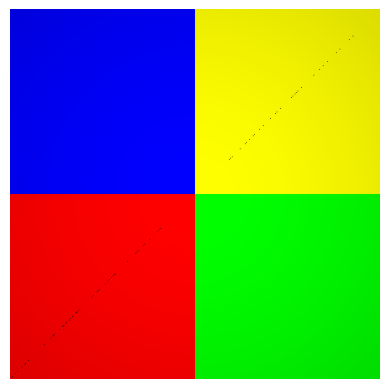

In [15]:
# To visualize UV as RGB, we map UV to RG and fix B to 0.0.
renderer.load_triangles(scene=scene)
renderer.render(
    scene.camera.view_matrix(),
    scene.camera.fov,
)
plt.imshow(np.flipud(output_image.to_numpy()))
plt.axis('off')
plt.show()

#### Bilinear Sampling
Bilinear sampling gets rid of the blocky effect that we just saw, we set the color of the pixel to the interpolated color from the texel surrounding it's corresponding UV.

Implement the `bilinearSample` function of `struct SharedTexture2DBuffer` in file `src/cs248a_renderer/slang_shaders/texture/texture.slang`. Upon a successful implementation, rendering a plane with this texture onto a 512x512 sized canvas should get the following smooth output:  

![bilinear](../../assets/bilinear.png)

In [16]:
scene = Scene()
mesh = getObject(object_type=ObjectType.PLANE,\
                material=MaterialType.ALBEDO_TEXTURE,\
                filtering_method=FilteringMethod.BILINEAR,\
                texture_map_path=TINY_TEXTURE_IMAGE_PATH)
scene.add_object(mesh)
cam = scene.camera
eye = glm.vec3(50.0, 50.0, 120.5)
lookAt = glm.vec3(50.0, 50.0, 0.0)

cam.transform.position = eye
cam.transform.rotation = glm.quatLookAt(glm.normalize(lookAt-eye), glm.vec3(0.0, 1.0, 0.0))
scene

SceneObject(name=root, transform=Transform3D(position=vec3( 0, 0, 0 ), rotation=quat( 1, 0, 0, 0 ), scale=vec3( 1, 1, 1 )), children=[
  SceneObject(name=object_7, transform=Transform3D(position=vec3( 0, 0, 0 ), rotation=quat( 1, 0, 0, 0 ), scale=vec3( 1, 1, 1 )), children=[
  ])
])

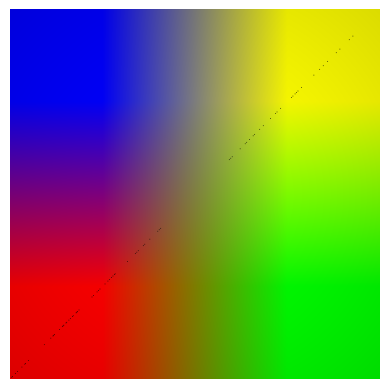

In [17]:
# To visualize UV as RGB, we map UV to RG and fix B to 0.0.
renderer.load_triangles(scene=scene)
renderer.render(
    scene.camera.view_matrix(),
    scene.camera.fov,
)
plt.imshow(np.flipud(output_image.to_numpy()))
plt.axis('off')
plt.show()

### Texture Minification
We just saw the phenomenon of texture magnification, where texture map's area is too small to fill in the whole canvas. Let's now look at what happens when texture map's area is too large.

In this section, we are going to render image of plane such that it's parallel to the ground. When a plane is rendered such that it's parallel to the ground, the points near the horizon need to sample over large space on the texture map, giving rise to texture minification in these regions.

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

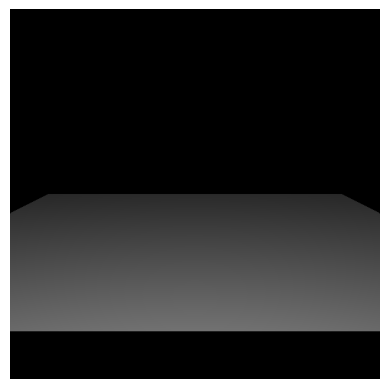

In [18]:
########### LOAD PLANE WITH UNIFORM COLOR ###########

scene = Scene()
mesh = getObject(object_type=ObjectType.PLANE,\
                 material=MaterialType.UNIFORM,\
                 filtering_method=FilteringMethod.NEAREST)
scene.add_object(mesh)

########### SET CAMERA SUCH THAT PLANE IS ON GROUND ###########

cam = scene.camera
eye = glm.vec3(50.0, -50.0, 25.0)
lookAt = glm.vec3(50.0, 100.0, 0.0)

cam.transform.position = eye
cam.transform.rotation = glm.quatLookAt(glm.normalize(lookAt-eye), glm.vec3(0.0, 1.0, 0.0))

########### RENDER ###########

renderer.load_triangles(scene=scene)
renderer.render(
    scene.camera.view_matrix(),
    scene.camera.fov,
)
plt.imshow(np.flipud(output_image.to_numpy()))
plt.axis('off')

#### Download the Texture Map
Download the `fabric.png` from the assignment 2 resources folder: [https://drive.google.com/file/d/1b7Kb9xMul02BalnZp5vNvb7-K98NdyNx/view?usp=drive_link](https://drive.google.com/file/d/1b7Kb9xMul02BalnZp5vNvb7-K98NdyNx/view?usp=drive_link)

Place it in the `resources` folder under the root directory of the repository (e.g.

#### Creation of Mipmaps
Let's prepare for the texture minification by creating a hierarchy of mipmaps. We are going to use `fabric.png` which is a texture map of a fabric at 512x512 resolution. At this point, recall that the output image is also declared to be of the same size. 

A mipmap is a texture map that's prefiltered using low-pass filtering. Level 0 mipmap is unfilted texture map. Higher level mipmaps are low-filtered (downsampled) with more strength, which reduces their size. Level i mipmap is 2^i times smaller than the original one!

Here we show the different levels of the mipmap of the texture that you're going to overlay onto the plane.

![mipmaps](../../assets/mipmaps.png)

To get this result, let's implement the function `generate_mipmaps` in `src/cs248a_renderer/model/material.py`. This function takes level 0 texture image as input generates the mipmap hierarchy from it. 

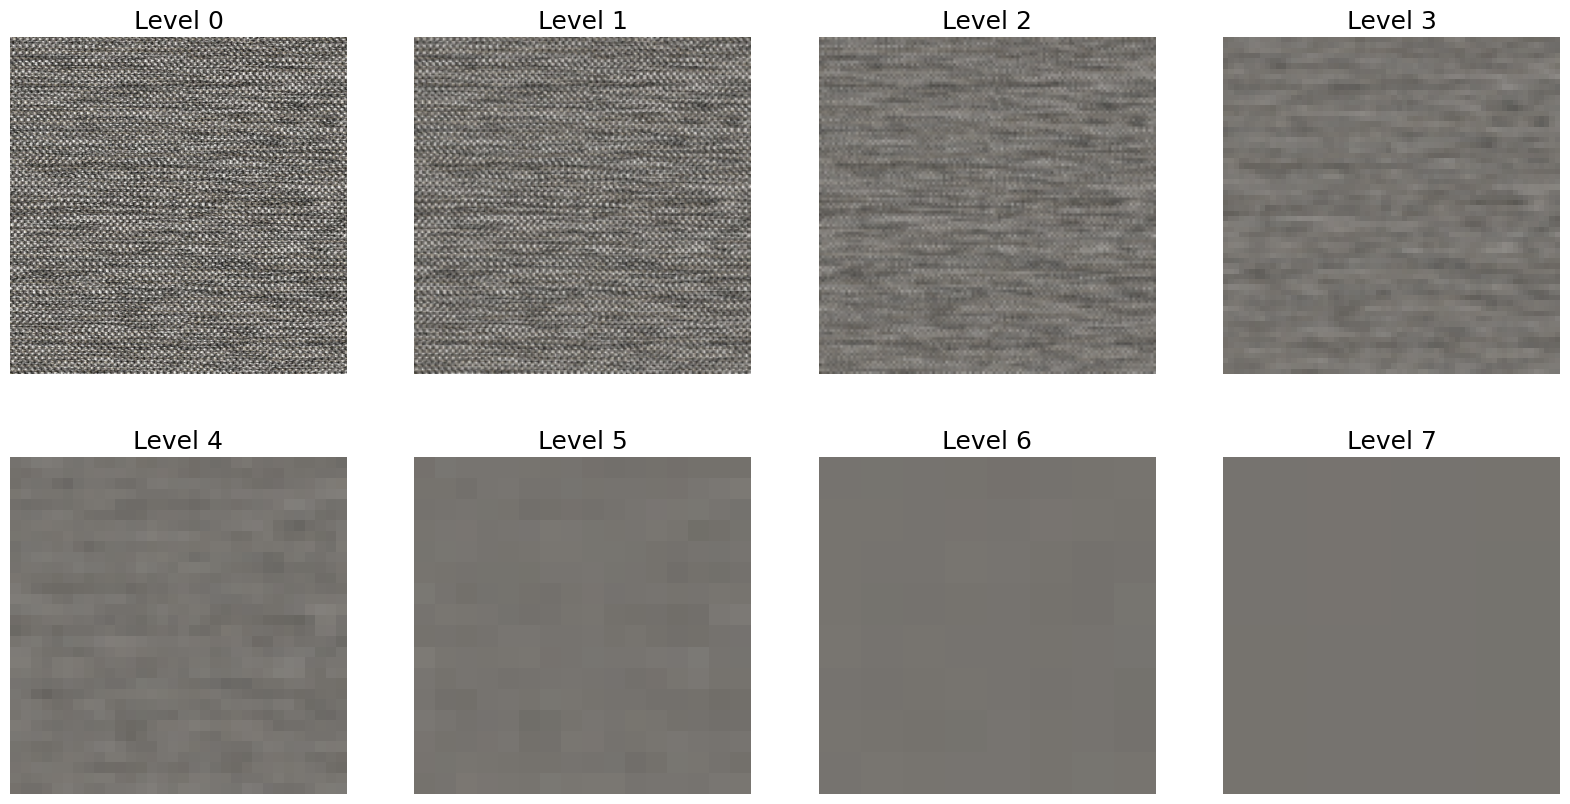

In [19]:
ALBEDO_TEXTURE_IMAGE_PATH = "../../resources/fabric.png"
material = MaterialField(
    uniform_value=glm.vec3(1.0, 1.0, 1.0),
    use_texture=True,
    filtering_method=FilteringMethod.NEAREST,
    texture_map_path=ALBEDO_TEXTURE_IMAGE_PATH,
)
plt.figure(figsize=(20, 10))
for i in range(2):
    for j in range(len(material.textures) // 2):
        plt.subplot(2, 4, i * len(material.textures) // 2 + j + 1)
        plt.imshow(material.textures[i * 4 + j])
        plt.title(f"Level {i * 4 + j}", fontsize=18)
        plt.axis('off')
plt.show()


In [27]:
# Helper function to render the plane with different filtering methods
def renderPlane(filtering_method: FilteringMethod, \
                visualize_albedo: bool=True, \
                visualize_level_of_detail: bool=False, \
                texture_map_path: str=ALBEDO_TEXTURE_IMAGE_PATH
    ):
    scene = Scene()
    mesh = getObject(object_type=ObjectType.PLANE,\
                    material=MaterialType.ALBEDO_TEXTURE,\
                    filtering_method=filtering_method,\
                    texture_map_path=texture_map_path)
    scene.add_object(mesh)

    cam = scene.camera
    eye = glm.vec3(50.0, -50.0, 25.0)
    lookAt = glm.vec3(50.0, 100.0, 0.0)

    cam.transform.position = eye
    cam.transform.rotation = glm.quatLookAt(glm.normalize(lookAt-eye), glm.vec3(0.0, 1.0, 0.0))

    renderer.load_triangles(scene=scene)

    if visualize_albedo and visualize_level_of_detail:
        raise ValueError("Cannot visualize both albedo and level of detail in the same render call. Choose one!")

    renderer.render(
        scene.camera.view_matrix(),
        scene.camera.fov,
        visualize_albedo=visualize_albedo,
        visualize_level_of_detail=visualize_level_of_detail
    )
    return np.flipud(output_image.to_numpy())

[WARN] Slang compiler warnings:
/Users/anniev18/Desktop/CS248A/asst2/src/cs248a_renderer/slang_shaders/./primitive/volume.slang(25): warning 41010: non-void function does not return in all cases
    public Optional<RayHitResult> hit(Ray ray, SharedTexture3DBuffer<float4> volumeTexBuf)
                                  ^~~



#### Aliasing at horizon
If we use the interpolation methods implemented so far to render plane with this texture, we see aliasing effect at the horizon.

<div style="display: flex; gap: 10px;">

  <figure style="width: 50%; margin: 0; text-align: center;">
    <img src="../../assets/aliasing_nearest.png" style="width: 100%;" />
    <figcaption style="margin-top: 5px; font-weight: bold;">Nearest</figcaption>
  </figure>

  <figure style="width: 50%; margin: 0; text-align: center;">
    <img src="../../assets/aliasing_bilinear.png" style="width: 100%;" />
    <figcaption style="margin-top: 5px; font-weight: bold;">Bilinear</figcaption>
  </figure>

</div>

<!-- ![aliasing_nearest](../../assets/aliasing_nearest.png) ![aliasing_bilinear](../../assets/aliasing_bilinear.png) -->

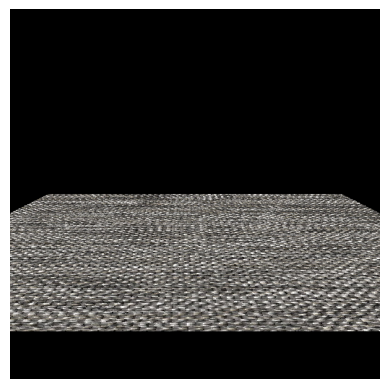

In [28]:
output_image_np = renderPlane(FilteringMethod.NEAREST, 
                           visualize_albedo=True, 
                           visualize_level_of_detail=False,
                           texture_map_path=ALBEDO_TEXTURE_IMAGE_PATH)
plt.imshow(output_image_np)
plt.axis('off')
plt.show()

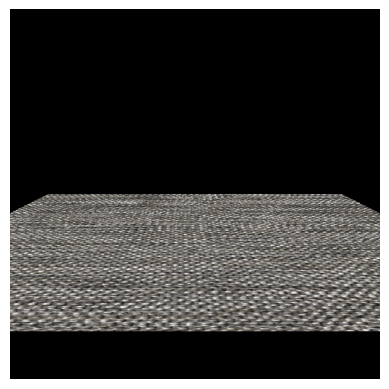

In [29]:
output_image_np = renderPlane(FilteringMethod.BILINEAR, 
                           visualize_albedo=True, 
                           visualize_level_of_detail=False,
                           texture_map_path=ALBEDO_TEXTURE_IMAGE_PATH)
plt.imshow(output_image_np)
plt.axis('off')
plt.show()

#### Why are we observing aliasing in this example?
Farther a point is from the camera, lower will be the texture resolution at that point. But previous interpolation method do not take resolution into account while samplint a texel. For eg. the line at the horizon in this rendering is supposed to be from a lower mipmap level. But previous interpolation methods simply sample from level 0 mipmap without low-pass filtering which culminates in aliasing.

### Treating the Aliasing with Mipmaps
As we defined earlier, a hierarchy of mipmaps contains low-pass filtered texture map. The hierarchy starts from level 0 (no filtering) and then each level progressively low-pass filters the previous one. 

To make use of these mipmaps for texturing, we have to find the relationship between UV space and screen space. This is quantified by the mipmap level $D$. For every hit point from ray to surface, we have to find the level of mipmap at it in order to use them.
#### How to calculate mipmap level $D$ at the hit point? 
The mipmap level $D$ is computed as follows:

$\rho_x = \sqrt{\left(\frac{\partial u}{\partial x}\right)^2 + \left(\frac{\partial v}{\partial x}\right)^2}, \quad 
\rho_y = \sqrt{\left(\frac{\partial u}{\partial y}\right)^2 + \left(\frac{\partial v}{\partial y}\right)^2}$  
$\rho = \max(\rho_x, \rho_y)$  
$D = \log_2\left(\rho\right)$

Here, **$\rho_x$:** is the length of the derivative vector in UV space relative to a step in the screen $x$ direction Similarlt, **$\rho_y$:** is the length of the derivative vector in UV space relative to a step in the screen $y$ direction.

##### But how does **$\rho_x$** and **$\rho_y$:** contribute to the Level of Detail ($D$)?
Each mipmap level $n$ is $\frac{1}{2^n}$ the size of the original. To find which level fits a footprint of size $\rho$, we solve for $n$ in $2^n = \rho$, which is:
$$n = \log_2(\rho)$$

##### What do different value of $D$ mean?
- $D \approx 0$ implies **1:1 Mapping** in texel space and screen space. This means we can directly sample from Level 0.
- $D < 0$ implies **Texture Magnification**. This means we are zooming into the texture map, and we've to use interpolation to find these texels.
- $D > 0$ implies **Texture Minification**. This means we are zooming out of texture map. This uses Mipmap Level $D$ to avoid aliasing.
  
#### Ray differential method
To implement this, we follow a ray differential method. So far you've shot one ray from the pixel center to find the hit point. In the ray differential method for LoD computation, we are going to shoot 4 more rays from a pixel.   

Each of these ray represents $\partial x^+$ and $\partial x^-$. That is, slightly perturbed ray in x direction (both positive and negative). We follow a similar procedure in $y$ direction of screen space. (Note that screen space ranges from 0-1 so you need to normalize $x$ accordingly).  

Each of these rays will return us hitpoints and we then get the UV at these hit points to compute $\rho_x$ and $\rho_y$ and then get LoD $D$ from it.

Below image demonstrates the mipmap levels of the plane (darker blue is lower level). Observe how the level increase as we move closer to the horizon.  

![bilinear_levels](../../assets/levels_bilinear.png)

Now let's minimize aliasing by using mipmaps. First, we'll get mipmap level at each hit point. To do this, implement the function `getLevel` in `src/cs248a_renderer/slang_shaders/renderer/triangle_renderer.slang` using ray differentials.


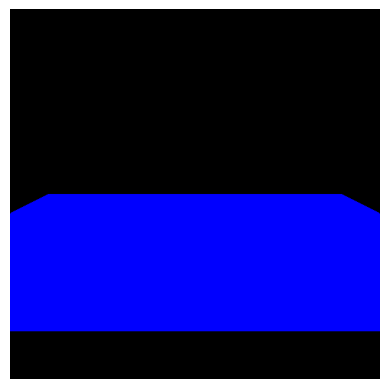

In [30]:
output_image_np = renderPlane(FilteringMethod.BILINEAR_DISCRETIZED_LEVEL, 
                           visualize_albedo=False, 
                           visualize_level_of_detail=True,
                           texture_map_path=ALBEDO_TEXTURE_IMAGE_PATH)
plt.imshow(output_image_np)
plt.axis('off')
plt.show()

Let's visualize the texture rendered with bilinear discretized level, which chooses approapriate mipmap according to the level to bilinearly sample the texel. It should produce an output as follows (note the smoothing at the horizon)

![bdl](../../assets/bdl.png)

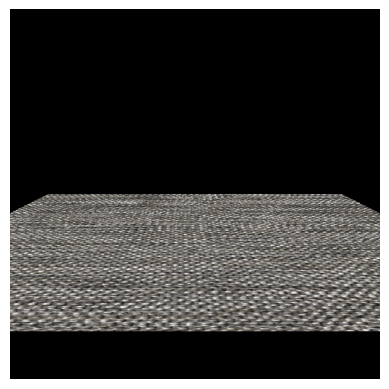

In [31]:
output_image_np = renderPlane(FilteringMethod.BILINEAR_DISCRETIZED_LEVEL, 
                           visualize_albedo=True, 
                           visualize_level_of_detail=False,
                           texture_map_path=ALBEDO_TEXTURE_IMAGE_PATH)
plt.imshow(output_image_np)
plt.axis('off')
plt.show()

#### Trilinear Filtering
While Bilinear filtering with discretized levels solves the problem of aliasing, it stumbles upon a new problem of discretization in levels. Specifically, observe a shift in the smoothness of the texture at the middle the image where the level is _suddenly_ increasing.

To smoothen this shift, we again resort to the ancient technique of interpolation. The only step trilinear filtering adds over the previous bilinear with discretized levels is interpolation in level space.

To do this, go ahead and implement the function `trilinearSample` in `src/cs248a_renderer/slang_shaders/texture/texture.slang`. Levels from a successful implementation should look like the following (note the smoothened levels as we look towards the horizon)  

![trilinear_levels](../../assets/trilineat_levels.png)

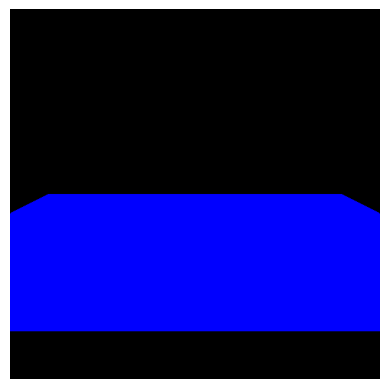

In [32]:
output_image_np = renderPlane(FilteringMethod.TRILINEAR, 
                           visualize_albedo=False, 
                           visualize_level_of_detail=True,
                           texture_map_path=ALBEDO_TEXTURE_IMAGE_PATH)
plt.imshow(output_image_np)
plt.axis('off')
plt.show()

Finally, let's look at the trilinearly filtered image of the textured plane. Note a smooth gradation in the texture as we look towards the horizon.

![trilinear](../../assets/trilinear_filt.png)

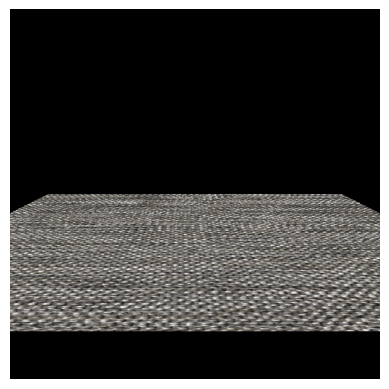

In [33]:
output_image_np = renderPlane(FilteringMethod.TRILINEAR, 
                           visualize_albedo=True, 
                           visualize_level_of_detail=False,
                           texture_map_path=ALBEDO_TEXTURE_IMAGE_PATH)
plt.imshow(output_image_np)
plt.axis('off')
plt.show()